# CAB420, Practical 9 - Question 1 Template
## Face Recognition with an AutoEncoder

The encoders and decoders lecture example (Semi-Supervised Learning, ``CAB420_Encoders_and_Decoders_Example_3_Semi_Supervised_Learning.ipynb``) uses a network which is an autoencoder, with a class-based output also included, and resulting from a couple of dense layers connected to the bottleneck. This network allows the autoencoder to class specific information, as the bottleneck layer must be useful for both reconstruction, and classification.

Extend this idea to face recognition. In doing so you should:
* Use the YaleB dataset to train the model. Look at the Week 7 practical solutions for code to prepare YaleB (and other face recognition datasets) for use in a DCNN.
* Modify the class-based output of the network to classify the face into the target identities.
* Use the trained network to extract bottleneck features, and train a simple classifier (i.e. a CKNN) for face recognition. Feel free to reuse code from earlier weeks (i.e. the week 7 practical solution) to achieve this.
* Evaluate the same network on the ORL and Yale face datasets. Consider how well the network trained on YaleB generalises to these other datasets, and compare this to the results observed in previous practicals that have dealt with this data (Week 6 and 7).

### Relevant Examples

The semi-supervised and multi-task examples are of most use here:
* ``CAB420_Encoders_and_Decoders_Example_2_Multiple_Outputs.ipynb``
* ``CAB420_Encoders_and_Decoders_Example_3_Semi_Supervised_Learning.ipynb``

Any of the earlier examples, and in particular prac solutions that have worked with the face rec data are also going to give you some good code to re-use (though a lot of this is already copied below).

### Suggested Packages

It's tensorflow, with our other favourites thrown in (sklearn, matplotlib).

In [16]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import keras
from keras.datasets import fashion_mnist
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.utils import to_categorical
from keras.models import Model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

import numpy
import scipy

from sklearn.manifold import TSNE

### Step 1: Code Reuse

We're making heavy use of code from previous examples. In particular:
* ``CAB420_Encoders_and_Decoders_Example_3_Semi_Supervised_Learning.ipynb``, which used an autoencoder with a classification head connected to the bottleneck layer. The network setup is taken from here and adapted slightly.
* The Week 7 practical solution, which used the face rec datasets with a triplet network. The data loading, and face rec classifier training and evaluation is taken from here

Given the heavy code reuse, commentary with this solution will be somewhat sparse, and will focus on the new bits.

#### Data Loading

Load YaleB, reshape into images, and display it. We'll also convert the labels to a categorical here as we want to use those with a classification head.

In [17]:
yale_b = scipy.io.loadmat('YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = numpy.random.randint(count, size=6)
    test_frames = numpy.append(test_frames, indexes[f])

gnd = keras.utils.to_categorical(gnd - 1)
train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]

train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_fea.transpose(), (32, 32, 1, len(test_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

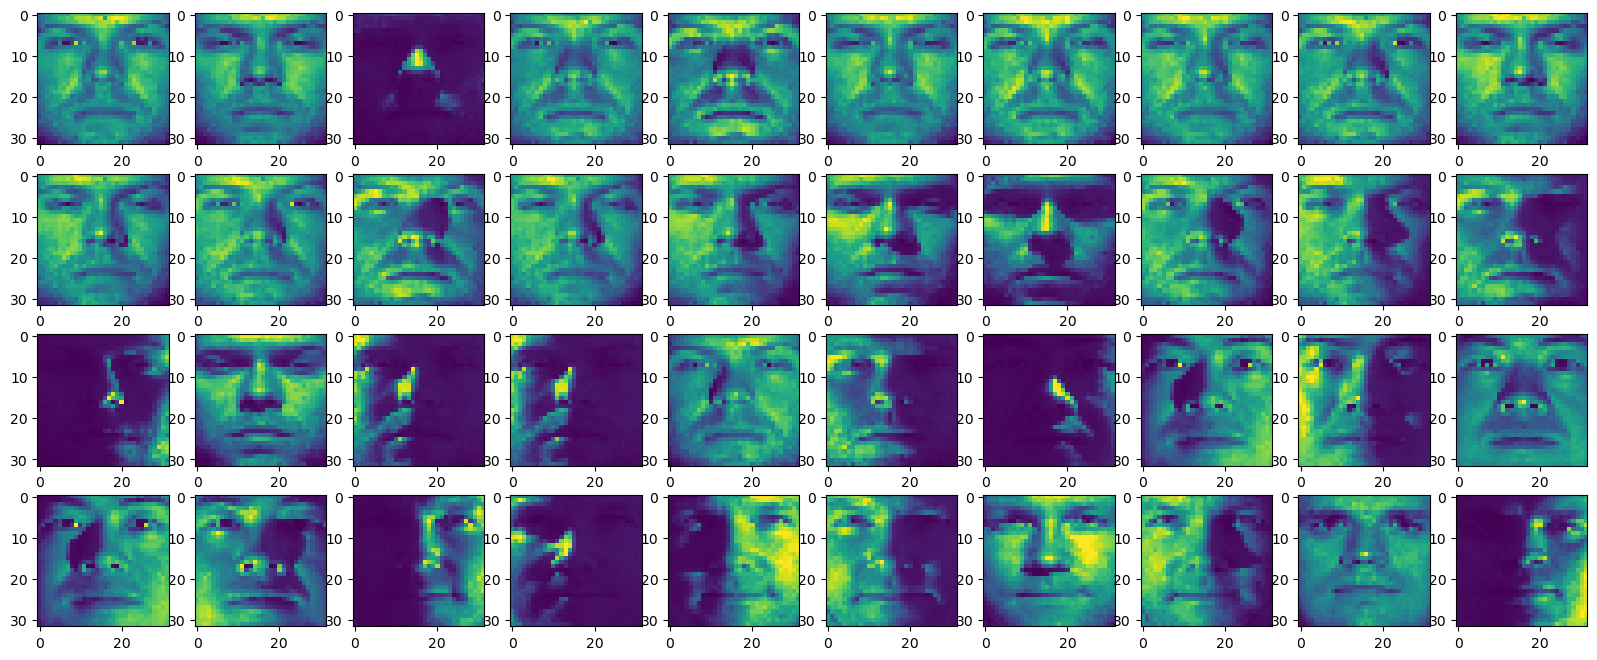

In [18]:
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])   

### Step 2: Network Setup and Training

Build your network here.

The intent here is to train an autoencoder to also learn an embedding that's useful for classification. To do this we need to get information on the underlying identity into the network. The easiest way to do this, and what was done in the lecture example you are adapting, is to take the bottleneck layer and attach a classifier to this, given you a second network output. From that point, you can train your network to perform both the classification (face ID) and autoencoder tasks.

To simplify the next step, it is recommended that you give a name to your bottleneck layer, i.e.

```
    ... some network layers to encode the input ...    
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)

    encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)
    ... some layers to decode the output and get some losses ...
```

You can name your encoded representation whatever you like (I've used the very boring *bottleneck* in the above, but perhaps you'd like to call your layer Gareth, or Sharon?)

In [19]:
input_img = Input(shape=(32, 32, 1))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
bottleneck = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

class_output = Flatten()(bottleneck)
class_output = Dense(64, activation='relu')(class_output)
class_output = Dense(38, activation='softmax')(class_output)

# decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(bottleneck)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, [decoded, class_output])
autoencoder.compile(optimizer='AdamW', loss=['mean_squared_error', 'categorical_crossentropy'], jit_compile=False)
print(autoencoder.summary())
#plot_model(autoencoder, show_shapes=True, dpi=60)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32, 8) │         80 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32, 8) │        584 │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16, 8) │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │      1,168 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │      2,320 │ conv2d_15[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 16)  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 8, 8, 32)  │      4,640 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 8, 8, 32)  │      9,248 │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck          │ (None, 4, 4, 32)  │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 4, 4, 32)  │      9,248 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 4, 4, 32)  │      9,248 │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 8, 8, 32)  │          0 │ conv2d_20[0][0]   │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 8, 8, 16)  │      4,624 │ up_sampling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 8, 16)  │      2,320 │ conv2d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 16, 16,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16, 8) │      1,160 │ up_sampling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16, 8) │        584 │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 512)       │          0 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 32, 32, 8) │          0 │ conv2d_24[0][0]   │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 80,535 (314.59 KB)

 Trainable params: 80,535 (314.59 KB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
history = autoencoder.fit(train_fea_reshape, [train_fea_reshape, train_gnd],
                epochs=25,
                batch_size=32,
                shuffle=True,
                validation_data=(test_fea_reshape, [test_fea_reshape, test_gnd]), verbose=True)

Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - loss: 3.7204 - val_loss: 3.6650
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6484 - val_loss: 3.5887
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4968 - val_loss: 3.3550
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1458 - val_loss: 3.0837
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5205 - val_loss: 2.3278
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9089 - val_loss: 1.9420
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3213 - val_loss: 1.5117
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9667 - val_loss: 1.2450
Epoch 9/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7183 - val_loss: 1.0372
Epoch 10/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6046 - val_loss: 0.8323
Epoch 11/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4652 - val_loss: 0.8418
Epoch 12/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4728 - val

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


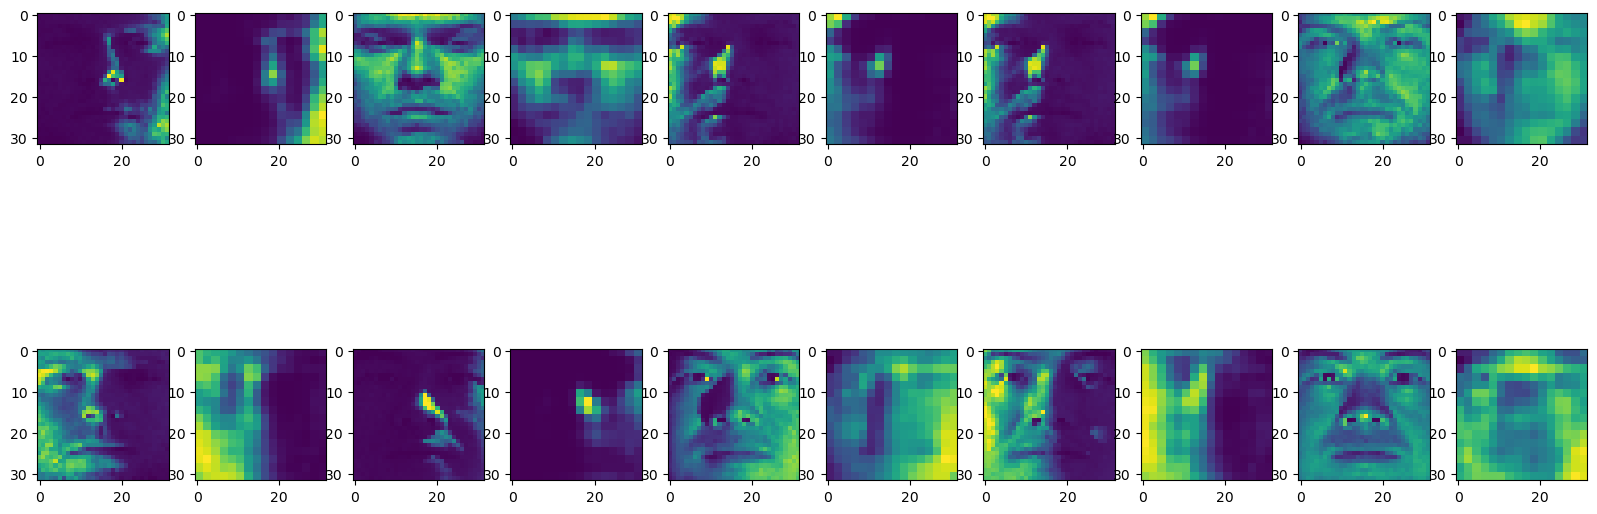

In [21]:
[sample_output, class_label] = autoencoder.predict(test_fea_reshape)
fig = plt.figure(figsize=[20, 8])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(test_fea_reshape[i,:,:,0])   

    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(sample_output[i,:,:,0])       

### Step 3: Getting Embeddings

Now, you can use the embeddings you learnt to do face rec. This will follow the same pattern used in the metric learning prac:
* Get the embeddings for the training and testing set
* Train a simple classifier, CKNN is our usual goto here
* Evaluate the model

The trick here is getting the embeddings. These are no longer the network outputs, but rather the internal representation of the network. This is where having a named layer is helpful as you can do this:

```
bottleneck_output = multitask_cnn.get_layer('bottleneck').output 
bottleneck_model = Model(inputs = multitask_cnn.input, outputs = bottleneck_output)
```

The above creates a new, truncated network (bottleneck_model), from a larger network by selecting out an internal layer (bottleneck) from our initial network. Using the named layer you created above, you can do the same thing.

An eval function, very much like our usual one, is provided below. Note however that in this setup, we've converted our ground truth data to a categorical rather than leaving it as just a class number. As such, the below eval function is getting the overall accuracy a little differently.

In [22]:
bottleneck_output = autoencoder.get_layer('bottleneck').output 
bottleneck_output = Flatten()(bottleneck_output)
bottleneck_model = Model(inputs = autoencoder.input, outputs = bottleneck_output)
bottleneck_model.compile(jit_compile=False)
bottleneck_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (MaxPooling2D)       │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,040 (70.47 KB)

 Trainable params: 18,040 (70.47 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
sample_output = bottleneck_model.predict(train_fea_reshape)
print(sample_output.shape)

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
(2200, 512)


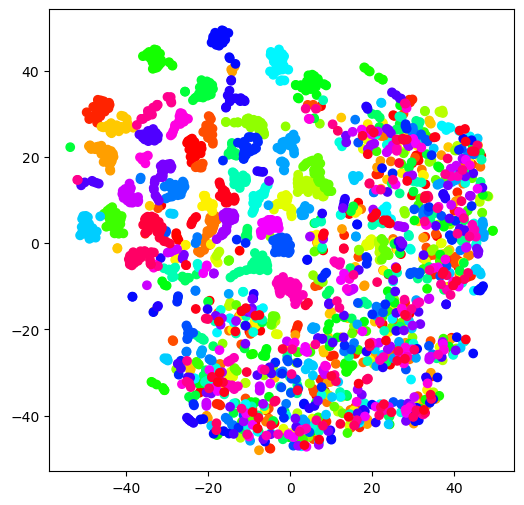

In [24]:
tsne_embeddings = TSNE(random_state=4).fit_transform(sample_output)
fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = keras.ops.argmax(train_gnd, axis=1), cmap='hsv');

In [25]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])

    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    matches = (pred == Y_train).numpy()
    conf.ax_.set_title('Training Set Performance: %s' % (sum(matches)/len(matches)));

    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    matches = (pred == Y_test).numpy()
    conf.ax_.set_title('Test Set Performance: %s' % (sum(matches)/len(matches)));  

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


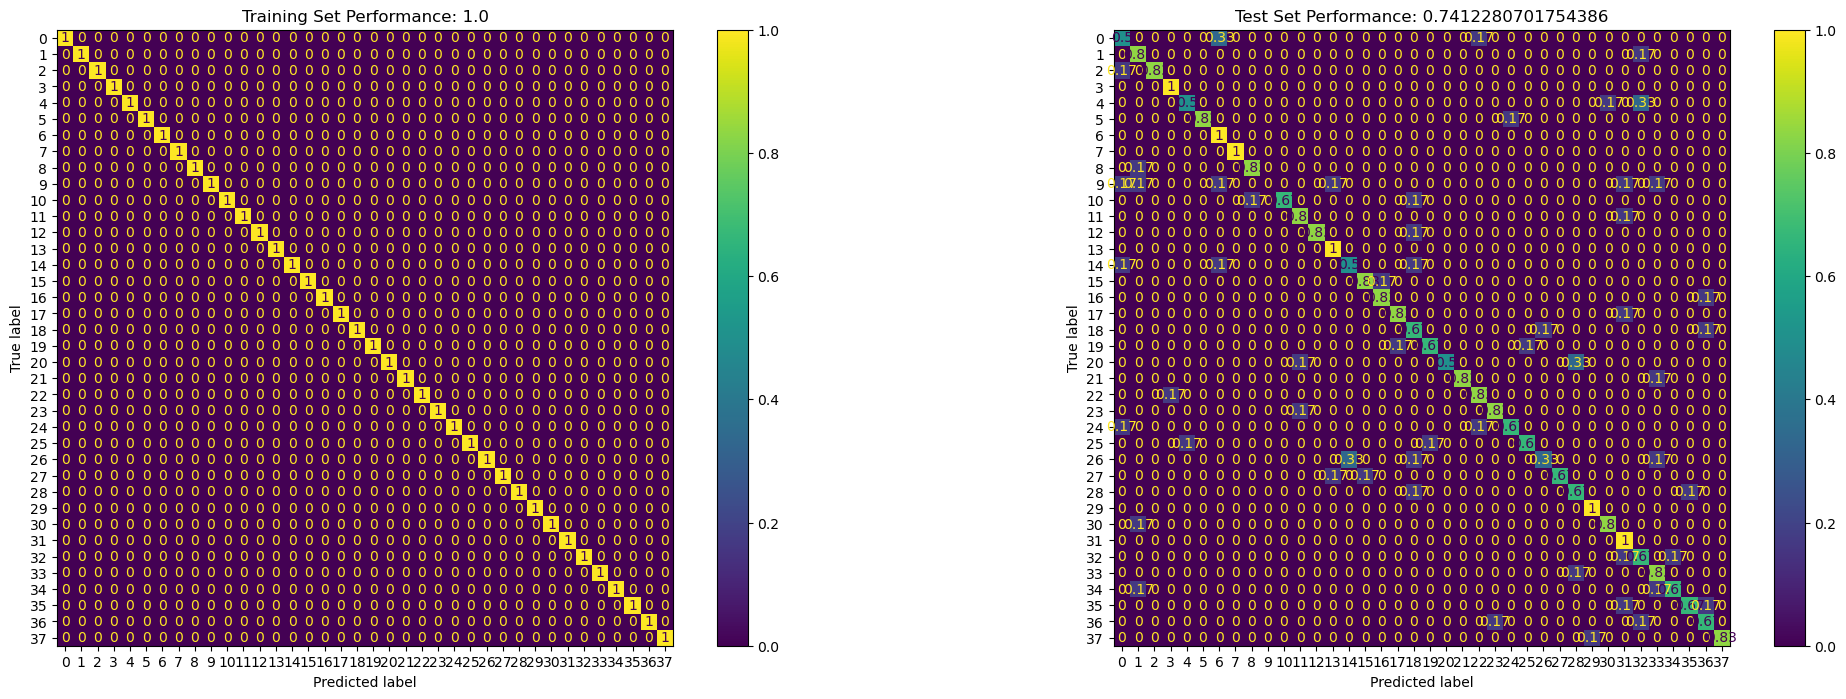

In [26]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
train_embeddings = bottleneck_model.predict(train_fea_reshape)
test_embeddings = bottleneck_model.predict(test_fea_reshape)

cknn.fit(train_embeddings, keras.ops.argmax(train_gnd, axis=1))
eval_model(cknn, train_embeddings, keras.ops.argmax(train_gnd, axis=1), test_embeddings, keras.ops.argmax(test_gnd, axis=1))

### Step 4: Generalisation

Now it's time to answer the eternal question, does it generalise?

Data loading code borrowed from elsewhere. The process here should be fairly familar:
* Using the trained network, encode the images for ORL and Yale
* Train and evaluate a simple classifier using these embeddings

### ORL

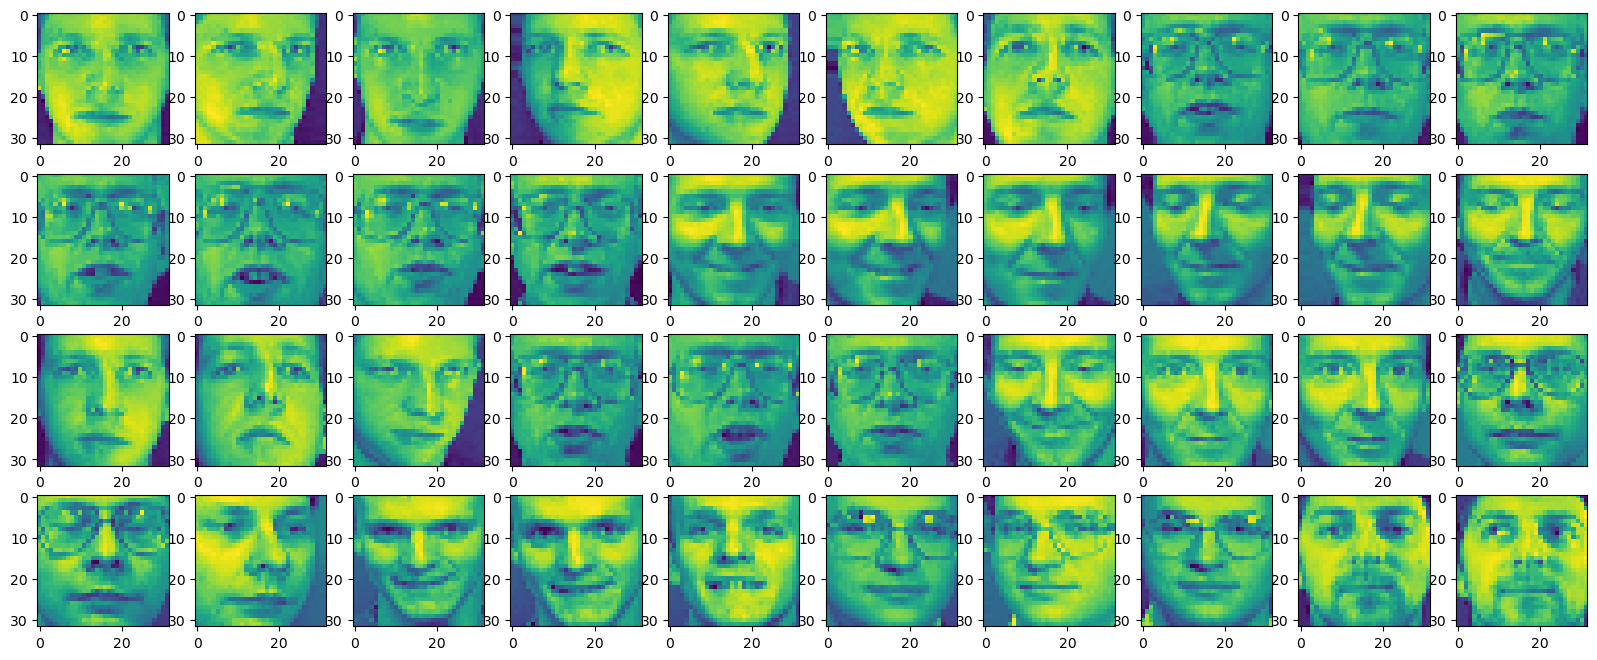

In [27]:
orl = scipy.io.loadmat('ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])

train_frames = []
for i in range(40):
    for j in range(7):
        train_frames.append(i*10 + j)
        
gnd = keras.utils.to_categorical(gnd)
train_fea = fea[train_frames, :]
train_gnd = gnd[train_frames, :]
test_fea = fea
test_gnd = gnd
test_fea = numpy.delete(test_fea, train_frames, 0)
test_gnd = numpy.delete(test_gnd, train_frames, 0)

train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_fea.transpose(), (32, 32, 1, len(test_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])      

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


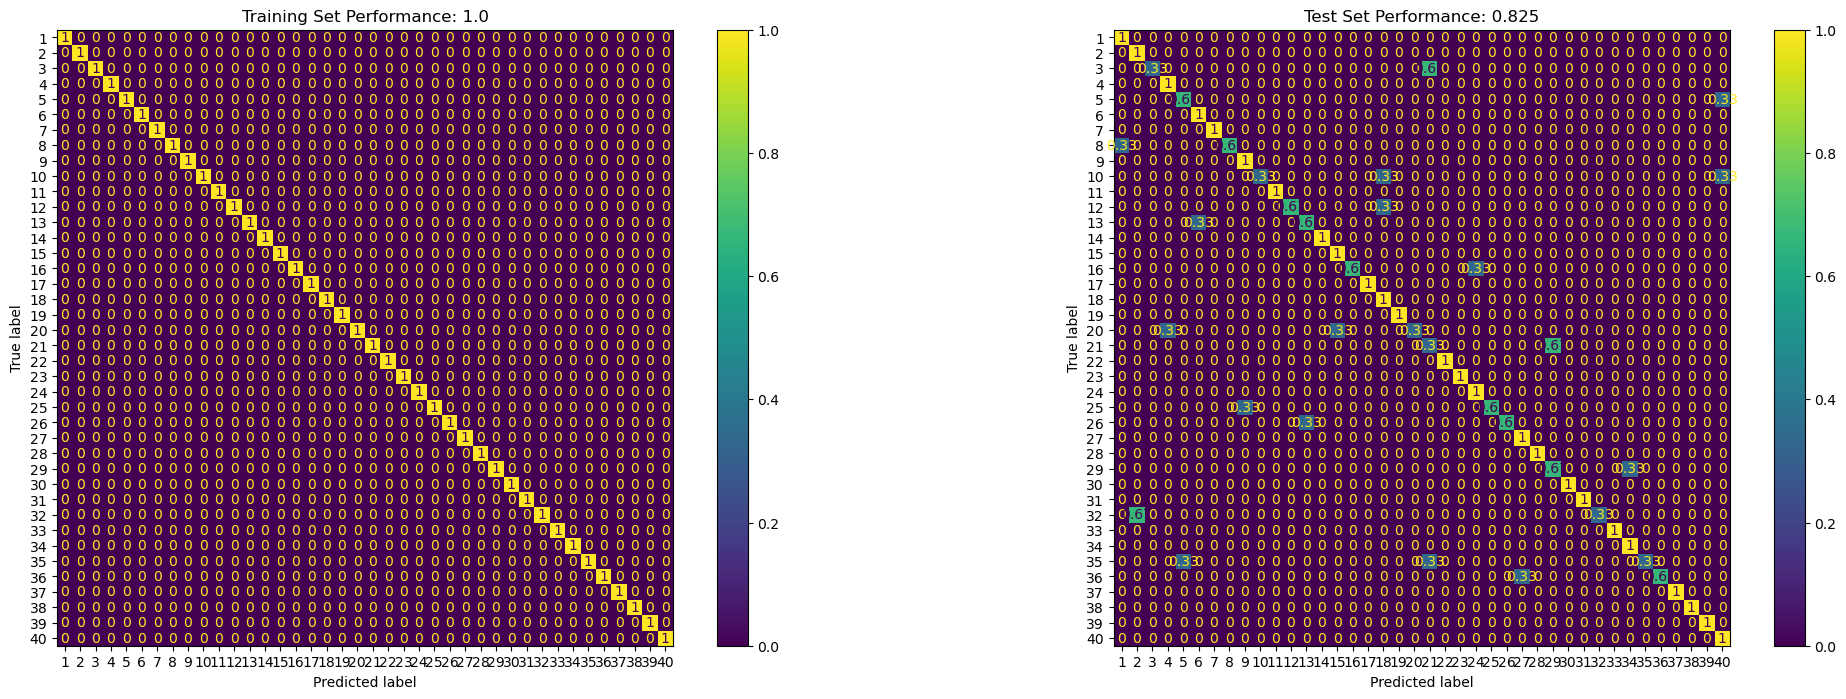

In [28]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
train_embeddings = bottleneck_model.predict(train_fea_reshape)
test_embeddings = bottleneck_model.predict(test_fea_reshape)

cknn.fit(train_embeddings, keras.ops.argmax(train_gnd, axis=1))
eval_model(cknn, train_embeddings, keras.ops.argmax(train_gnd, axis=1), test_embeddings, keras.ops.argmax(test_gnd, axis=1))

### Yale

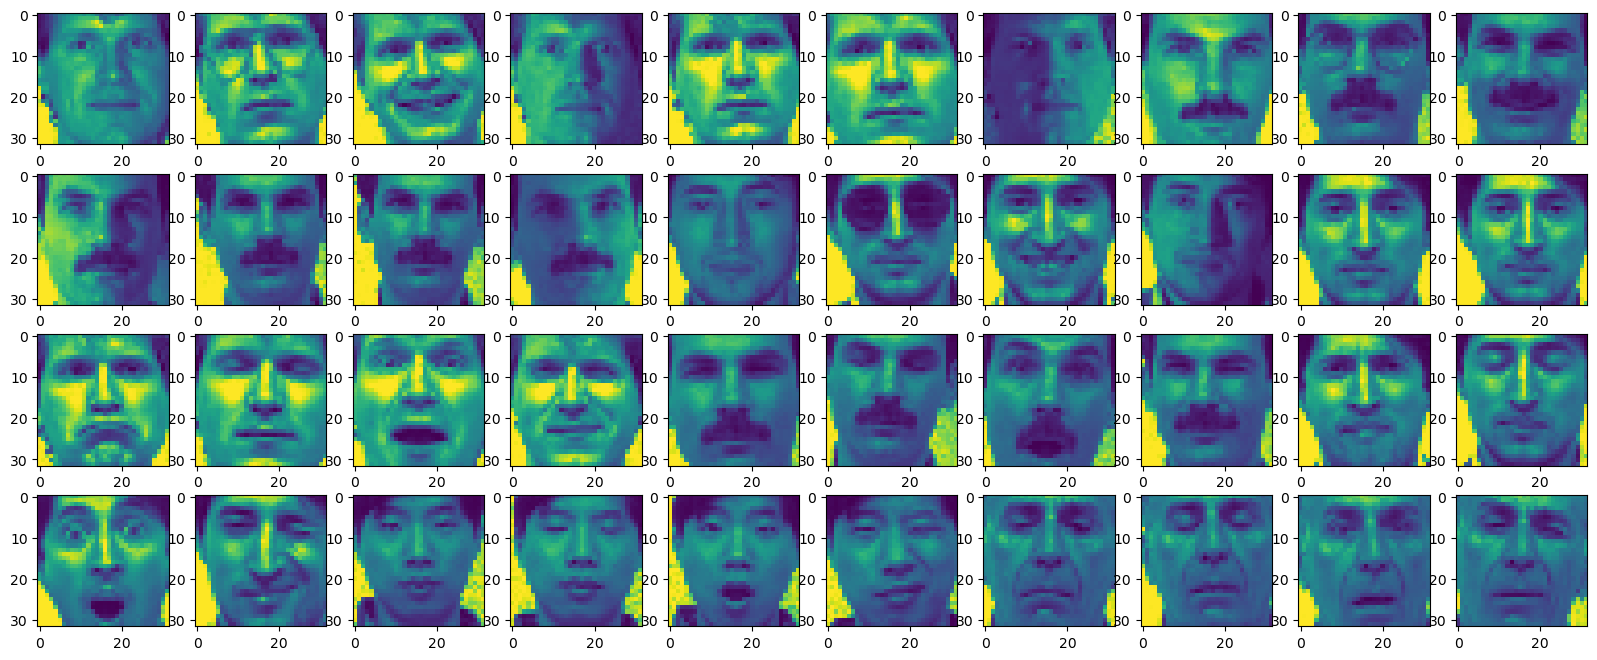

In [29]:
yale = scipy.io.loadmat('Yale_32x32.mat');
fea = yale['fea'] / 255.0
gnd = numpy.array(yale['gnd'])

train_frames = []
for i in range(15):
    for j in range(7):
        train_frames.append(i*11 + j)

gnd = keras.utils.to_categorical(gnd)
train_fea = fea[train_frames, :]
train_gnd = gnd[train_frames, :]
test_fea = fea
test_gnd = gnd
test_fea = numpy.delete(test_fea, train_frames, 0)
test_gnd = numpy.delete(test_gnd, train_frames, 0)

train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_fea.transpose(), (32, 32, 1, len(test_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])     

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


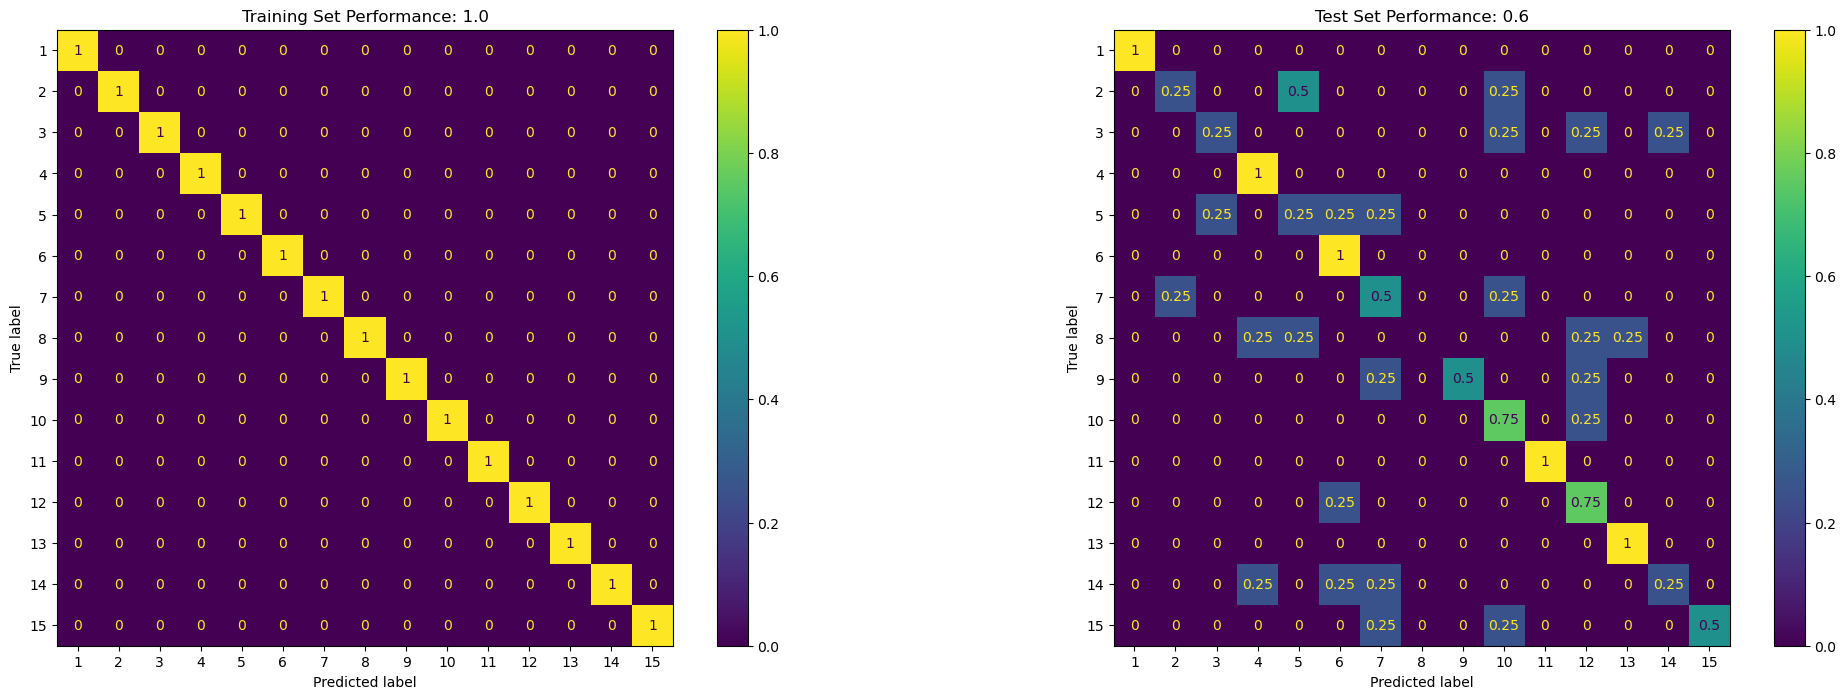

In [30]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
train_embeddings = bottleneck_model.predict(train_fea_reshape)
test_embeddings = bottleneck_model.predict(test_fea_reshape)

cknn.fit(train_embeddings, keras.ops.argmax(train_gnd, axis=1))
eval_model(cknn, train_embeddings, keras.ops.argmax(train_gnd, axis=1), test_embeddings, keras.ops.argmax(test_gnd, axis=1))